In [33]:
import unicodecsv

In [34]:
def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

In [35]:
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

In [36]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [37]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'account_key': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [38]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

In [39]:
def unique_elements_count(dictionary):
    unique_elements_set= set()
    for element in dictionary:
        unique_elements_set.add(element['account_key'])
    return unique_elements_set

In [40]:
enrollment_unique_students=unique_elements_count(enrollments)
engagement_unique_students=unique_elements_count(daily_engagement)

In [41]:
for enrollment in enrollments:
    if enrollment['account_key'] not in engagement_unique_students:
        print(enrollment)
        break

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


In [42]:
num_problem_students=0
for enrollment in enrollments:
    if enrollment['account_key'] not in engagement_unique_students \
    and enrollment['join_date'] != enrollment['cancel_date']:
        num_problem_students+=1
        print(enrollment)
num_problem_students        

{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 1, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), u'days_to_cancel': 59}
{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 3, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 6, 17, 0, 0), u'days_to_cancel': 99}
{u'status': u'current', u'is_udacity': True, u'is_canceled': False, u'join_date': datetime.datetime(2015, 2, 25, 0, 0), u'account_key': u'1101', u'cancel_date': None, u'days_to_cancel': None}


3

In [43]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [44]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [45]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print(len(non_udacity_enrollments))
print(len(non_udacity_engagement))
print(len(non_udacity_submissions))

1622
135656
3634


In [46]:
paid_students={}
for enrollment in non_udacity_enrollments:
    if enrollment['days_to_cancel'] is None or enrollment['days_to_cancel']>7:
        account_key=enrollment['account_key']
        enrollment_date=enrollment['join_date']
        if account_key not in paid_students or enrollment_date>paid_students[account_key]:
            paid_students[account_key]=enrollment_date
len(paid_students)

995

In [47]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days>=0

In [48]:
def remove_free_trial_cancels(data):
    new_data=[]
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

In [49]:
paid_enrollments=remove_free_trial_cancels(non_udacity_enrollments)
paid_engagements=remove_free_trial_cancels(non_udacity_engagement)
paid_submissions=remove_free_trial_cancels(non_udacity_submissions)
print(len(paid_enrollments))
print(len(paid_engagements))
print(len(paid_submissions))

1293
134549
3618


In [62]:
for engagement_record in paid_engagements:
    if engagement_record['num_courses_visited']>0:
        engagement_record['has_visited']=1
    else:
        engagement_record['has_visited']=0

In [63]:
paid_engagement_in_first_week=[]
for engagement in paid_engagements:
    account_key=engagement['account_key']
    join_date=paid_students[account_key]
    engagement_date=engagement['utc_date']
    if within_one_week(join_date, engagement_date):
        paid_engagement_in_first_week.append(engagement)
len(paid_engagement_in_first_week)

6919

In [64]:
from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account=group_data(paid_engagement_in_first_week, 'account_key')

In [65]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data
total_minutes_by_account=sum_grouped_items(engagement_by_account, 'total_minutes_visited')

In [66]:
import numpy as np

def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)

total_minutes = total_minutes_by_account.values()
describe_data(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


In [67]:
student_with_max_minutes=None
max_minutes=0
for student, total_minutes in total_minutes_by_account.items():
    if total_minutes>max_minutes:
        max_minutes=total_minutes
        student_with_max_minutes=student
print student, max_minutes

479 3564.7332645


In [68]:
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key']==student_with_max_minutes:
        print engagement_record

{u'lessons_completed': 4, u'num_courses_visited': 4, 'has_visited': 1, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, u'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, 'has_visited': 1, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, u'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, 'has_visited': 1, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, u'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, 'has_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, u'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, 'has_visited': 1, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, u'account_key': 

In [69]:
lessons_completed_by_account = sum_grouped_items(engagement_by_account, 'lessons_completed')
describe_data(lessons_completed_by_account.values())

Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


In [70]:
days_visited_by_account = sum_grouped_items(engagement_by_account, 'has_visited')
describe_data(days_visited_by_account.values())

Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7


In [95]:
subway_project_lesson_keys = ['746169184', '3176718735']
accounts_by_lesson_key = group_data(paid_submissions, 'lesson_key')
subway_project_submissions=accounts_by_lesson_key['746169184']+accounts_by_lesson_key['3176718735']

In [97]:
pass_subway_project=set()
for submission in subway_project_submissions:
    if submission['assigned_rating']=='PASSED' or submission['assigned_rating']=='DISTINCTION':
        pass_subway_project.add(submission['account_key'])
len(pass_subway_project)

647

In [99]:
passing_engagement = []
non_passing_engagement = []
for engagement in paid_engagement_in_first_week:
    if engagement['account_key'] in pass_subway_project:
        passing_engagement.append(engagement)
    else:
        non_passing_engagement.append(engagement)
len(passing_engagement), len(non_passing_engagement)

(4527, 2392)

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

In [127]:
import seaborn as sns

In [139]:
def analyze_data(data, key_name, field_name):
    grouped_data=group_data(data, key_name)
    summed_grouped_data=sum_grouped_items(grouped_data, field_name)
    data_values=summed_grouped_data.values()
    describe_data(data_values)
    plt.hist(data_values)
    plt.show()

Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645


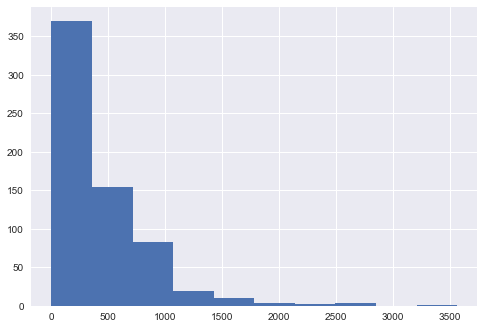

In [140]:
analyze_data(passing_engagement, 'account_key', 'total_minutes_visited')

Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933


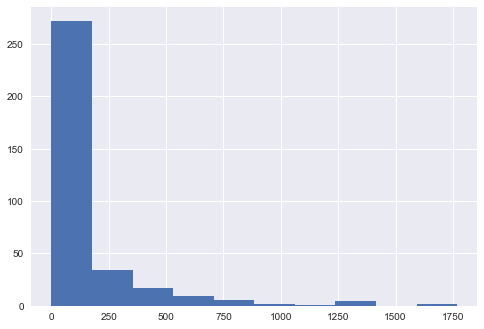

In [141]:
analyze_data(non_passing_engagement, 'account_key', 'total_minutes_visited')

Mean: 2.05255023184
Standard deviation: 3.14222705558
Minimum: 0
Maximum: 36


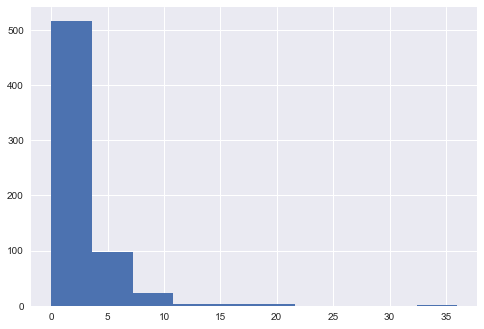

In [142]:
analyze_data(passing_engagement, 'account_key', 'lessons_completed')

Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27


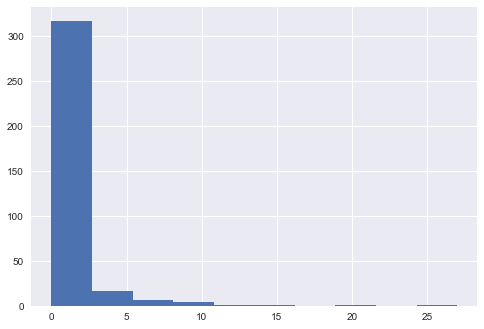

In [143]:
analyze_data(non_passing_engagement, 'account_key', 'lessons_completed')

Mean: 4.72642967543
Standard deviation: 3.7002397793
Minimum: 0
Maximum: 25


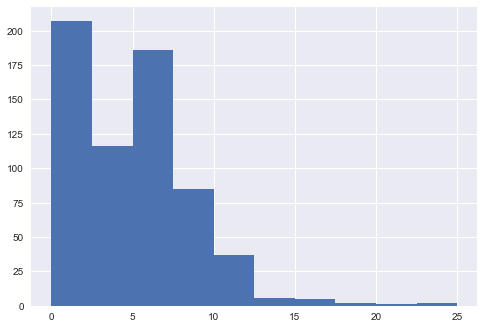

In [144]:
analyze_data(passing_engagement, 'account_key', 'num_courses_visited')

Mean: 2.58908045977
Standard deviation: 2.90670969025
Minimum: 0
Maximum: 18


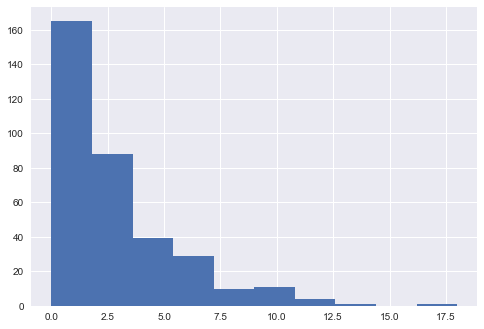

In [145]:
analyze_data(non_passing_engagement, 'account_key', 'num_courses_visited')

Mean: 3.38485316847
Standard deviation: 2.25882147092
Minimum: 0
Maximum: 7


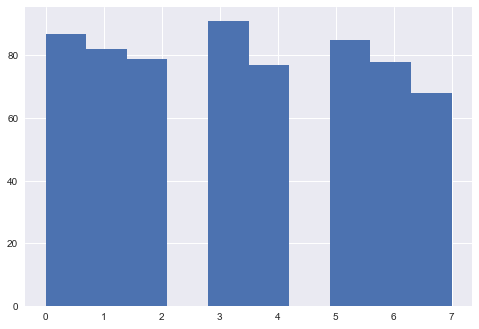

In [146]:
analyze_data(passing_engagement, 'account_key', 'has_visited')

Mean: 1.90517241379
Standard deviation: 1.90573144136
Minimum: 0
Maximum: 7


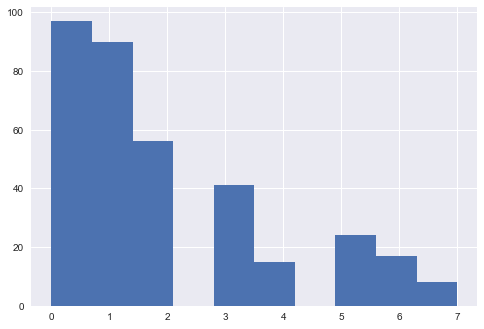

In [147]:
analyze_data(non_passing_engagement, 'account_key', 'has_visited')